## ML - Assignment 2: TMDB Box Office Prediction

*Submitted by: <br>
Arja Sivapiragasam, Arisa Seljestokken & Raida Talukdar*

### Problem description

In this notebook, we are looking at some sets of data gathered from the TMDB database. We have metadata on over 7000 movies, and are using a training set and a test set to predict a movie's worldwide box office revenue. 

### Imports

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
warnings.filterwarnings("ignore")
import ast
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

### Data loading and overview

In [3]:
# a function that reads all the data from a csv file to a DataFrame

train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
train = train_set.copy()
test = test_set.copy()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

In [6]:
train.shape, test.shape

((3000, 23), (4398, 22))

The training set has 23 columns, whereas the test set has only 22 columns because it does not have the revenue column. 

Most of the datatypes are objects and should be converted because the desired datatype is int64.

In [7]:
# The columns that are choosen below are objects containing text

dict_columns = ['genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

# The following function converts text to dictionaries

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x:
              {} if pd.isna(x) else ast.literal_eval(x) )
    return df

train = text_to_dict(train)
test = text_to_dict(test)

The original tables for the train and test data sets:

In [8]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [9]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


## Analyzing data

We will now look at some of the most significant attributes from the data sets, and use the various types of values to predict the revenue.

In [10]:
train.isnull().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
overview                    8
runtime                     2
poster_path                 1
revenue                     0
popularity                  0
budget                      0
genres                      0
imdb_id                     0
original_language           0
original_title              0
production_companies        0
crew                        0
production_countries        0
release_date                0
spoken_languages            0
status                      0
title                       0
Keywords                    0
cast                        0
id                          0
dtype: int64

This list shows the number of missing values for each attribute in descending order.



### belongs_to_collection and homepage:

Because belongs_to_collection and homepage contains the most numbers of missing values, we will use one-hot encoder to analyze and decide how much impact these features will have on the revenue. 

In [11]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1

test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

In [12]:
train['has_collection'] = 0
train.loc[train['belongs_to_collection'].isnull() == False, 'has_collection'] = 1

test['has_collection'] = 0
test.loc[test['belongs_to_collection'].isnull() == False, 'has_collection'] = 1

Take a look at the table to see the two new attributes:

In [13]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,has_homepage,has_collection
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,1
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,0
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,1,0
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,0



#### Plotting of has_collection and homepage against revenue:

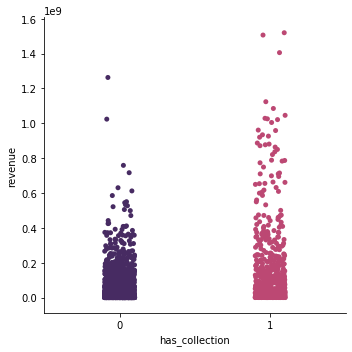

In [14]:
has_collection_palette = ['#472b62', '#bc4873']
sns.set_palette(has_collection_palette)
sns.catplot(x="has_collection", y="revenue",data=train)
plt.show()

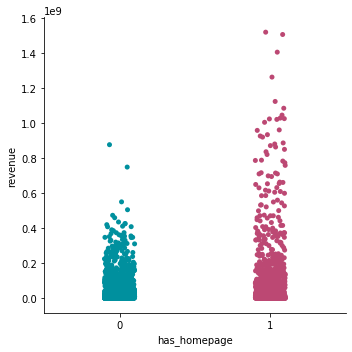

In [15]:
has_homepage_palette = ['#00909e', '#bc4873']
sns.set_palette(has_homepage_palette)
sns.catplot(x="has_homepage", y="revenue",data=train)
plt.show()

The has_collection plot shows that movies in collections are doing a bit better against revenue.

The has_homepage plot shows movies with a homepages are showing us the almost the same result as above.

Since we now have made new attributes has_collection and has_homepage we can now drop belongs_to_collection and homepage:

In [16]:
train.drop(columns=['belongs_to_collection', 'homepage'], axis =1, inplace=True)
test.drop(columns=['belongs_to_collection', 'homepage'], axis =1, inplace=True)

We have decided to drop the columns poster_path, imdb_id, status, overview, title and crew because we chose to assume they will have no impact on the revenue, or because the data is to complex to analyze:

In [17]:
train.drop(columns=['poster_path', 'imdb_id', 'status', 'overview', 'title', 'crew'], axis =1, inplace=True)
test.drop(columns=['poster_path', 'imdb_id', 'status', 'overview', 'title', 'crew'], axis =1, inplace=True)

Let's take a look at the missing values again:

In [18]:
train.isnull().sum().sort_values(ascending=False)

tagline                 597
runtime                   2
has_collection            0
production_companies      0
budget                    0
genres                    0
original_language         0
original_title            0
popularity                0
release_date              0
production_countries      0
has_homepage              0
spoken_languages          0
Keywords                  0
cast                      0
revenue                   0
id                        0
dtype: int64

### original_language:

original_language tells us which original language the movie has. This can be useful because we want to see if the language of the movie has any impact on the revenue.

Gathering information about the attribute:

In [19]:
train['original_language'].describe()

count     3000
unique      36
top         en
freq      2575
Name: original_language, dtype: object

In [20]:
train['original_language']

0       en
1       en
2       en
3       hi
4       ko
        ..
2995    en
2996    sv
2997    en
2998    en
2999    en
Name: original_language, Length: 3000, dtype: object

There are 36 different languages that are registered on the database, whereas English is the most common one.

A LabelEncoder can be used to make a new fitting attribute:

In [21]:
encoder = LabelEncoder()
og_language = train['original_language']
og_language_encoded = encoder.fit_transform(og_language)
og_language_encoded

encoder2 = LabelEncoder()
og_language_test = test['original_language']
og_language_encoded_test = encoder2.fit_transform(og_language_test)
og_language_encoded_test

array([19,  9,  9, ...,  9,  9, 12])

In [22]:
encoder.classes_

array(['ar', 'bn', 'cn', 'cs', 'da', 'de', 'el', 'en', 'es', 'fa', 'fi',
       'fr', 'he', 'hi', 'hu', 'id', 'it', 'ja', 'ko', 'ml', 'mr', 'nb',
       'nl', 'no', 'pl', 'pt', 'ro', 'ru', 'sr', 'sv', 'ta', 'te', 'tr',
       'ur', 'vi', 'zh'], dtype=object)

We have now made an array of integers and an array of strings. Both represents the unique languages. 

In [23]:
train['og_language'] = og_language_encoded
test['og_language'] = og_language_encoded_test

Looking at the train table:

In [24]:
train.head()

,id,budget,genres,original_language,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,Keywords,cast,revenue,has_homepage,has_collection,og_language
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",en,Hot Tub Time Machine 2,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,7
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,The Princess Diaries 2: Royal Engagement,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,7
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",en,Whiplash,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,1,0,7
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",hi,Kahaani,3.174936,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,13
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",ko,마린보이,1.148070,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,0,0,18


We can see that this new attribute is showing us the appropriate number that represents the language of the movie. We can now drop the original_language attribute:

In [25]:
train.drop(columns=['original_language'], axis =1, inplace=True)
test.drop(columns=['original_language'], axis =1, inplace=True)

### production_companies:

This attribute may help us to see if the production companies of the movies have an impact on the revenue.

In [26]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [27]:
list_prod_comp = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_prod_comp

list_prod_comp_test = list(test['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_prod_comp_test

[[],
 ['Woolner Brothers Pictures Inc.'],
 ['Warner Bros.', 'Outlaw Productions (I)', 'Miramax'],
 ['TS Productions', 'Micro scope', 'Phi Group'],
 [],
 ['Castle Rock Entertainment', 'Detour Filmproduction'],
 ['X-Filme Creative Pool',
  'ARTE',
  'Westdeutscher Rundfunk (WDR)',
  'ARD Degeto Film'],
 ['Walt Disney Pictures'],
 ['Ecosse Films', '2 Entertain', 'Bueprint Pictures'],
 ['Pixar Animation Studios'],
 ['Primetime Pictures', 'Emergence Entertainment'],
 ['Canal+',
  'Arte France',
  'Arte France Cinéma',
  'Hold Up Films',
  'Ciné+',
  "Agence Nationale pour la Cohésion Sociale et l'Egalité des Chances (ACSE)",
  'Région Ile-de-France',
  'Fonds Images de la Diversité',
  'Pyramide Distribution',
  'Centre National de la Cinématographie (CNC)',
  'Films Distribution',
  'Lilies Films',
  'Arte / Cofinova 9'],
 ['CAT Films', 'Mimosa Films'],
 [],
 ['The Weinstein Company', 'Summit Entertainment', 'Endgame Entertainment'],
 ['First Point Entertainment', 'Braeburn Entertainment']

The functions above creates lists of only the production company names for each movie.


In [28]:
Counter([i for j in list_prod_comp for i in j]).most_common()
Counter([i for j in list_prod_comp_test for i in j]).most_common()

[('Warner Bros.', 289),
 ('Universal Pictures', 275),
 ('Paramount Pictures', 232),
 ('Twentieth Century Fox Film Corporation', 203),
 ('Columbia Pictures', 145),
 ('Metro-Goldwyn-Mayer (MGM)', 123),
 ('New Line Cinema', 123),
 ('Touchstone Pictures', 95),
 ('Walt Disney Pictures', 85),
 ('Canal+', 84),
 ('Columbia Pictures Corporation', 79),
 ('TriStar Pictures', 68),
 ('Relativity Media', 67),
 ('Miramax Films', 64),
 ('United Artists', 61),
 ('Village Roadshow Pictures', 53),
 ('DreamWorks SKG', 51),
 ('Regency Enterprises', 50),
 ('Amblin Entertainment', 45),
 ('Lionsgate', 40),
 ('Fox Searchlight Pictures', 40),
 ('Summit Entertainment', 37),
 ('StudioCanal', 37),
 ('Dimension Films', 37),
 ('Working Title Films', 33),
 ('Orion Pictures', 32),
 ('Imagine Entertainment', 32),
 ('Dune Entertainment', 32),
 ('Film4', 31),
 ('Hollywood Pictures', 31),
 ('The Weinstein Company', 30),
 ('New Regency Pictures', 28),
 ('DreamWorks Animation', 28),
 ('Lions Gate Films', 28),
 ('Scott Free 

This gives us the information that the most common production companies are Warner Bros., Universal Pictures and Paramount Pictures.

In [29]:
# converting to numbers
multilabel_binarizer = MultiLabelBinarizer()
prod_comp_encoded = multilabel_binarizer.fit_transform(list_prod_comp)

In [30]:
multilabel_binarizer_test = MultiLabelBinarizer()
prod_comp_encoded_test = multilabel_binarizer_test.fit_transform(list_prod_comp_test)
prod_comp_encoded_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

The MultiLabelBinarizer gives us preferable data that we can work with. Then we will use the information that we have on the top 3 production companies to iterate through all the indexes in this attribute to return '1' if the movie has one of the top 3 prodcution companies:

In [31]:
np.set_printoptions(threshold=sys.maxsize)
index_1 = np.where(multilabel_binarizer.classes_ == 'Warner Bros.')
index_2 = np.where(multilabel_binarizer.classes_ == 'Universal Pictures')
index_3 = np.where(multilabel_binarizer.classes_ == 'Paramount Pictures')
print(index_1, index_2, index_3)

top3_prod_comp = [0]*3000

for index, item in enumerate(prod_comp_encoded):
    if item[index_1] == 1 or item[index_2] == 1 or item[index_3] == 1:
        top3_prod_comp[index] = 1
        
top3_prod_comp   

(array([3514], dtype=int64),) (array([3403], dtype=int64),) (array([2458], dtype=int64),)


[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,


In [32]:
np.set_printoptions(threshold=sys.maxsize)
index1 = np.where(multilabel_binarizer_test.classes_ == 'Warner Bros.')
index2 = np.where(multilabel_binarizer_test.classes_ == 'Universal Pictures')
index3 = np.where(multilabel_binarizer_test.classes_ == 'Paramount Pictures')
print(index_1, index_2, index_3)

top3_prod_comp_test = [0]*4398

for index, item in enumerate(prod_comp_encoded_test):
    if item[index1] == 1 or item[index2] == 1 or item[index3] == 1:
        top3_prod_comp_test[index] = 1
        
top3_prod_comp_test   

(array([3514], dtype=int64),) (array([3403], dtype=int64),) (array([2458], dtype=int64),)


[0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,


Both the arrays shows us exactly that. We can now drop the original attribute:

In [33]:
train['top3_prod_comp'] = top3_prod_comp
test['top3_prod_comp'] = top3_prod_comp_test

#### Plotting of the top 3 production_companies against revenue:

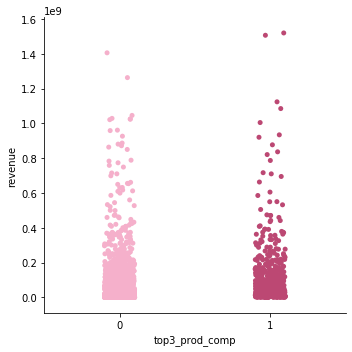

In [34]:
top3_prod_comp_palette = ['#f5b0cb', '#bc4873']
sns.set_palette(top3_prod_comp_palette)
sns.catplot(x="top3_prod_comp", y="revenue",data=train)
plt.show()

This shows us that movies are doing fine against revenue regardless of which production company they have.

In [35]:
train.drop(columns=['production_companies'], axis =1, inplace=True)
test.drop(columns=['production_companies'], axis =1, inplace=True)

### genres:

There are movies containing multiple genres, and by looking at them we may get an understanding of which ones are the most repetative ones.

In [36]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [37]:
print('Number of genres in movies:')

test['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in movies:


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

There are 972 movies containing 2 genres, 900 containing 3 genres, etc.

In [38]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [39]:
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

The list above shows us the name of the genre along with the number of movies containing the genre. The most common ones are Drama, Comedy and Thriller.

Now we are going to use MultiLabelBinarizer to make new attributes for each movie genre:

In [40]:
list_genres_train = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_genres_test = list(test['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [41]:
multilabel_binarizer_train = MultiLabelBinarizer()
multilabel_binarizer_test = MultiLabelBinarizer()

genre_encoded = multilabel_binarizer_train.fit_transform(list_genres_train)
genre_encoded_test = multilabel_binarizer_test.fit_transform(list_genres_test)

In [42]:
df_multilabel_data_train = pd.DataFrame(genre_encoded, columns=multilabel_binarizer_train.classes_)
df_multilabel_data_test = pd.DataFrame(genre_encoded_test, columns=multilabel_binarizer_test.classes_)

train[multilabel_binarizer_train.classes_] = df_multilabel_data_train
test[multilabel_binarizer_test.classes_] = df_multilabel_data_test

In [43]:
train.drop(columns=['genres'], axis =1, inplace=True)
test.drop(columns=['genres'], axis =1, inplace=True)

Looking at the table again with the new attributes. '1' marks what each movie's genres are:

In [44]:
train.head()

,id,budget,original_title,popularity,production_countries,release_date,runtime,spoken_languages,tagline,Keywords,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,14000000,Hot Tub Time Machine 2,6.575393,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...",...,0,0,0,0,0,0,0,0,0,0
1,2,40000000,The Princess Diaries 2: Royal Engagement,8.248895,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...",...,0,0,0,0,1,0,0,0,0,0
2,3,3300000,Whiplash,64.299990,"[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...",...,0,0,0,0,0,0,0,0,0,0
3,4,1200000,Kahaani,3.174936,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...",...,0,0,0,0,0,0,0,1,0,0
4,5,0,마린보이,1.148070,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,{},...,0,0,0,0,0,0,0,1,0,0


Looking at the multilabel classes:

In [45]:
multilabel_binarizer_train.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [46]:
multilabel_binarizer_test.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'War', 'Western'], dtype=object)

The test set does not include a movie with the genre TV Movie, and the train set only has one movie belonging to this genre. Therefore we can just remove the TV Movie genre column:

In [47]:
train.drop(columns=['TV Movie'], axis =1, inplace=True)


### Spoken languages:

This attribute tells us what languages are in each movie. We are looking at this attribute to deduce the impact it has one the revenue.

In [48]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [49]:
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [50]:
test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    3121
2     770
3     286
4     106
5      50
0      42
6      19
9       2
8       2
Name: spoken_languages, dtype: int64

The differences between the training set and the test set. Based on these, we see that the most common ones are the movies only have one spoken language. The most amount of languages in a movie is 8.

In [51]:
list_of_slanguage = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_slanguage_test = list(test['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [52]:
Counter([i for j in list_of_slanguage for i in j]).most_common()

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27),
 ('Polski', 25),
 ('Magyar', 24),
 ('Latin', 23),
 ('svenska', 22),
 ('ภาษาไทย', 22),
 ('Český', 20),
 ('עִבְרִית', 15),
 ('ελληνικά', 15),
 ('Türkçe', 13),
 ('Dansk', 13),
 ('Nederlands', 10),
 ('فارسی', 10),
 ('Tiếng Việt', 10),
 ('اردو', 8),
 ('Română', 8),
 ('తెలుగు', 7),
 ('Kiswahili', 7),
 ('Norsk', 7),
 ('No Language', 7),
 ('suomi', 6),
 ('Український', 6),
 ('Srpski', 4),
 ('Afrikaans', 4),
 ('Gaeilge', 3),
 ('Català', 3),
 ('বাংলা', 3),
 ('ਪੰਜਾਬੀ', 3),
 ('Somali', 3),
 ('Íslenska', 3),
 ('български език', 2),
 ('shqip', 2),
 ('Bahasa indonesia', 2),
 ('Slovenčina', 2),
 ('Esperanto', 2),
 ('euskera', 2),
 ('isiZulu', 2),
 ('Hrvatski', 2),
 ('қазақ', 1),
 ('Wolof', 1),
 ('Eesti', 1),
 ('پښتو', 1)]

The above list is a counter for the number of each language. The function below is iterating through all the indexes in this attribute. This is so we can plot the number of languages against the revenue.

In [53]:
number_of_spoken_language = [0]*3000
number_of_spoken_language_test = [0]*4398

for index, item in enumerate(list_of_slanguage): 
            number_of_spoken_language[index] = len(item)
            
for index, item in enumerate(list_of_slanguage_test): 
            number_of_spoken_language_test[index] = len(item)
    
train['number_of_spoken_languages'] = number_of_spoken_language
test['number_of_spoken_languages'] = number_of_spoken_language_test

#### Plotting of spoken_language against revenue:

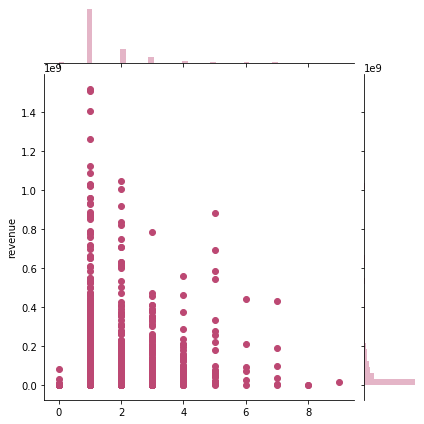

In [54]:
number_of_spoken_language_palette = ['#bc4873']
sns.set_palette(number_of_spoken_language_palette)
sns.jointplot(number_of_spoken_language, train.revenue);

From plotting the number of spoken languages against the revenue we can deduce that it does, in fact, have an impact on revenue. The more movies that contains 1 or 2 spoken languages, the better it does in relative to the revenue.

We can now include the new attribute in our dataframe, and delete the spoken_language attribute:

In [55]:
train.drop(columns=['spoken_languages'], axis =1, inplace=True)
test.drop(columns=['spoken_languages'], axis =1, inplace=True)

### production_countries

This attribute has shown to be quite important in regards to predict the revenue. Let us have a look in the following:

In [56]:
list_prod_countr = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_prod_countr_test = list(test['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [57]:
Counter([i for j in list_prod_countr for i in j]).most_common()

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10),
 ('Hungary', 9),
 ('United Arab Emirates', 9),
 ('Austria', 8),
 ('Switzerland', 8),
 ('Romania', 8),
 ('Greece', 7),
 ('Norway', 7),
 ('Argentina', 6),
 ('Chile', 6),
 ('Finland', 6),
 ('Israel', 5),
 ('Turkey', 5),
 ('Iran', 5),
 ('Poland', 5),
 ('Morocco', 3),
 ('Philippines', 3),
 ('Taiwan', 3),
 ('Bulgaria', 3),
 ('Bahamas', 3),
 ('Serbia', 2),
 ('Iceland', 2),
 ('Cambodia', 2),
 ('Malta', 2),
 ('Pakistan', 2),
 ('Qatar', 2),
 ('Tunisia', 2),
 ('Ukraine', 2),
 ('Singapore', 2),
 ('Indonesia', 2)

We decided to go directly into the Counter-function to see the list that is containing the name of the production country, and the related numbers of them. USA is without a doubt the most common production company. 

We are now mostly interested in what movies that are produced in the USA. Once again, we would like to iterate through the indexes in this attribute to set mark a '1' at every movie that is produced in the USA: 

In [58]:
produced_in_usa = [0]*3000
produced_in_usa_test = [0]*4398

for index, item in enumerate(list_prod_countr):
    for i in item: 
        if i == 'United States of America':
            produced_in_usa[index] = 1

for index, item in enumerate(list_prod_countr_test):
    for i in item: 
        if i == 'United States of America':
            produced_in_usa_test[index] = 1            

In [59]:
train['produced_in_USA'] = produced_in_usa
test['produced_in_USA'] = produced_in_usa_test


#### Plotting the new attribute produced_in_USA against revenue:

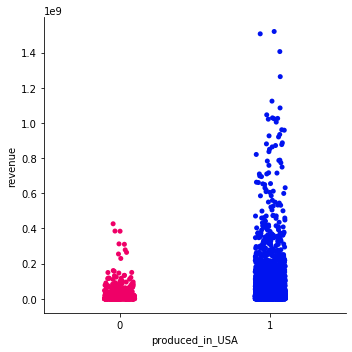

In [60]:
produced_in_USA_palette = ['#ef0067','#0013ef']
sns.set_palette(produced_in_USA_palette)
sns.catplot(x="produced_in_USA", y="revenue",data=train)
plt.show()

We can tell from observing this plot that a movine being produced in the USA has a significant impact on revenue. We can now delete the old production_countries attribute:

In [61]:
train.drop(columns=['production_countries'], axis =1, inplace=True)
test.drop(columns=['production_countries'], axis =1, inplace=True)

Let us now look at how both the data sets are looking like:

In [62]:
train.head()

,id,budget,original_title,popularity,release_date,runtime,tagline,Keywords,cast,revenue,...,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA
0,1,14000000,Hot Tub Time Machine 2,6.575393,2/20/15,93.0,The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,...,0,0,0,0,0,0,0,0,1,1
1,2,40000000,The Princess Diaries 2: Royal Engagement,8.248895,8/6/04,113.0,It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,...,0,0,0,1,0,0,0,0,1,1
2,3,3300000,Whiplash,64.299990,10/10/14,105.0,The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,...,0,0,0,0,0,0,0,0,1,1
3,4,1200000,Kahaani,3.174936,3/9/12,122.0,NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,...,0,0,0,0,0,1,0,0,2,0
4,5,0,마린보이,1.148070,2/5/09,118.0,NaN,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,...,0,0,0,0,0,1,0,0,1,0


In [63]:
test.head()

,id,budget,original_title,popularity,release_date,runtime,tagline,Keywords,cast,has_homepage,...,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA
0,3001,0,ディアルガVSパルキアVSダークライ,3.851534,7/14/07,90.0,Somewhere Between Time & Space... A Legend Is ...,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,...,0,0,0,0,0,0,0,0,2,1
1,3002,88000,Attack of the 50 Foot Woman,3.559789,5/19/58,65.0,A titanic beauty spreads a macabre wave of hor...,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,...,1,0,0,0,1,0,0,0,1,1
2,3003,0,Addicted to Love,8.085194,5/23/97,100.0,A Comedy About Lost Loves And Last Laughs,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,...,0,0,0,1,0,0,0,0,1,1
3,3004,6800000,Incendies,8.596012,9/4/10,130.0,The search began at the opening of their mothe...,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...",1,...,0,0,1,0,0,0,1,0,3,0
4,3005,2000000,Inside Deep Throat,3.217680,2/11/05,92.0,It was filmed in 6 days for 25 thousand dollar...,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...",0,...,0,0,0,0,0,0,0,0,1,1



### tagline:

Does movie taglines play an important role in captivating the viewers worldwide? Does this have an impact on the revenue?

In [64]:
for i, e in enumerate(train['tagline'][:10]):
    print(i, e)

0 The Laws of Space and Time are About to be Violated.
1 It can take a lifetime to find true love; she's got 30 days!
2 The road to greatness can take you to the edge.
3 nan
4 nan
5 nan
6 Fear The Demon That Doesn't Fear God
7 Different channels. Different truths.
8 Set sail for Muppet mayhem!
9 Back together for the first time, again.


In [65]:
train['has_tagline'] = 0
train.loc[train['tagline'].isnull() == False, 'has_tagline'] = 1

test['has_tagline'] = 0
test.loc[test['tagline'].isnull() == False, 'has_tagline'] = 1

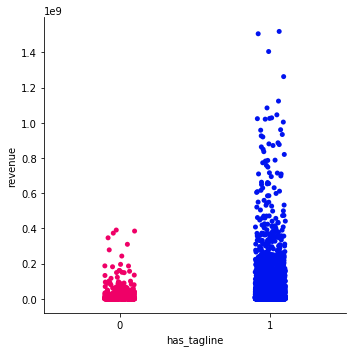

In [66]:
has_tagline_palette = ['#ef0067','#0013ef']
sns.set_palette(has_tagline_palette)
sns.catplot(x="has_tagline", y="revenue", data=train)
plt.show()

We are observing that the taglines does indeed play an important role on captivating the viewers worldwide. Dropping the previous attributes:

In [67]:
train.drop(columns=['tagline'], axis=1, inplace=True)
test.drop(columns=['tagline'], axis=1, inplace=True)


### release_date:

We are breaking down the release dates into days to see which days of the week gets the highest revenue.

Starting with converting from object type to pandas datatime type:

In [68]:
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

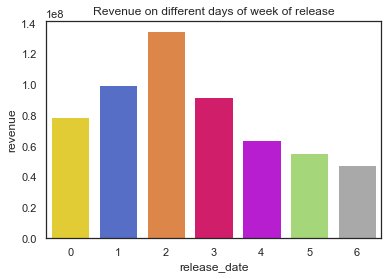

In [69]:
# Styling
release_day_palette = ['#ffe119','#4363d8','#f58231','#ef0067','#cd00ed','#a4e56b','#a9a9a9']
sns.set(style="white")

# Pandas dataframe.sort_index() function sorts objects by labels along the given axis
release_day = train['release_date'].value_counts().sort_index()

# Pandas .groupby function groups DataFrame by using a mapper or by a series of columns
release_day_revenue = train.groupby(['release_date'])['revenue'].sum()
release_day_revenue.index = release_day_revenue.index.dayofweek  #day_name()

sns.barplot(release_day_revenue.index, release_day_revenue, data = train, palette = release_day_palette, ci=0)
plt.title('Revenue on different days of week of release')
plt.show()

| Monday |Tuesday | Wednesday | Thursday | Friday | Saturday| Sunday | 
|--|--|--|--|--|--|--|
|0|1|2|3|4|5|6|

The table above represents each day of the week in the barplot. We can see that movies that are released on Wednesdays get the highest revenue compared to the other days. We will now add this new attribute into our data:

In [70]:
train['release_day'] = train['release_date'].dt.dayofweek 
test['release_day'] = test['release_date'].dt.dayofweek

train['release_day'].value_counts()
#test['release_day'].value_counts()

4    1335
3     609
2     450
1     196
5     158
0     133
6     119
Name: release_day, dtype: int64

The above numbers shows us how many movies that are released in each day of the week (the numbers on the left representing the same weekdays as the table above). We can see even though most releases happens on Fridays, the most revenues happens on Wednesdays.

Replacing samples with missing values with the mean value:

In [71]:
test['release_day'] = test['release_day'].fillna( test['release_day'].mean() )

We can now drop the attribute release_date:

In [72]:
train.drop(columns=['release_date'], axis=1, inplace=True)
test.drop(columns=['release_date'], axis=1, inplace=True)


### runtime:

#### Plotting runtime against revenue:

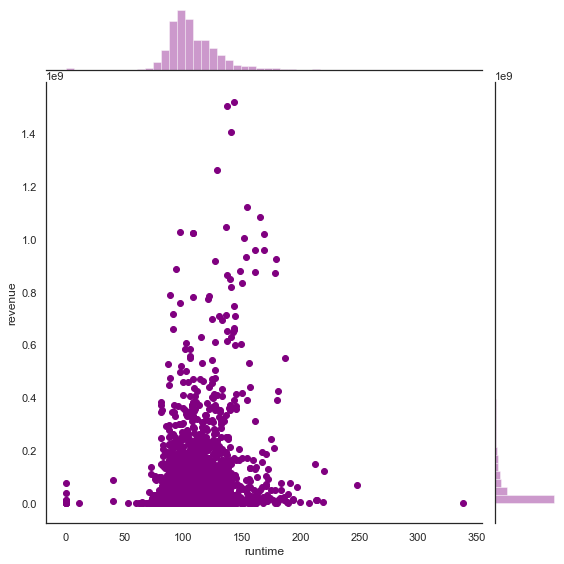

In [73]:
sns.jointplot(x="runtime", y="revenue", data=train,
             height=8, ratio=6, color="purple")
plt.show()

We do see from the plot above that movies that has a runtime roughly from 90 minutes to 140 minutes are the ones that are doing the best against the revenue.

The runtime attribute is of type float64, but we want to convert this attribute into a int64 type. Before doing this, we have to take care of the missing values in this attribute. It seems reasonable to replace the missing values with either the mean, or the median value of all the runtime values. We will check which one makes the most sense to replace the missing values with.

There are only two samples with missing values in this attribute. Therefore, we decided to replace these with the mean value.

In [74]:
train['runtime'] = train['runtime'].fillna( train['runtime'].mean() )
test['runtime'] = test['runtime'].fillna( test['runtime'].mean() )

Checking that runtime has no missing values left:

In [75]:
train.isnull().sum().sort_values(ascending=False)

release_day                   0
has_homepage                  0
Animation                     0
Adventure                     0
Action                        0
top3_prod_comp                0
og_language                   0
has_collection                0
revenue                       0
Crime                         0
cast                          0
Keywords                      0
runtime                       0
popularity                    0
original_title                0
budget                        0
Comedy                        0
Documentary                   0
has_tagline                   0
Romance                       0
produced_in_USA               0
number_of_spoken_languages    0
Western                       0
War                           0
Thriller                      0
Science Fiction               0
Mystery                       0
Drama                         0
Music                         0
Horror                        0
History                       0
Foreign 

We now have to drop the samples that have '0.0' as values in the runtime attribute:

In [76]:
train = train[train.runtime != 0.0]
test = test[test.runtime != 0.0]

Checking that samples with the minimum runtime is not equal to '0.0':

In [77]:
min_runtime = min(train['runtime'])
print('Min. runtime:', min_runtime)

min_runtime_test = min(test['runtime'])
print('Min. runtime test:', min_runtime_test)

Min. runtime: 11.0
Min. runtime test: 25.0



### Now looking at the data sets one last time:

In [78]:
train.head()

,id,budget,original_title,popularity,runtime,Keywords,cast,revenue,has_homepage,has_collection,...,Mystery,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA,has_tagline,release_day
0,1,14000000,Hot Tub Time Machine 2,6.575393,93.0,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,...,0,0,0,0,0,0,1,1,1,4
1,2,40000000,The Princess Diaries 2: Royal Engagement,8.248895,113.0,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,...,0,1,0,0,0,0,1,1,1,4
2,3,3300000,Whiplash,64.299990,105.0,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,1,0,...,0,0,0,0,0,0,1,1,1,4
3,4,1200000,Kahaani,3.174936,122.0,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,...,0,0,0,1,0,0,2,0,0,4
4,5,0,마린보이,1.148070,118.0,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,0,0,...,0,0,0,1,0,0,1,0,0,3


In [79]:
test.head()

,id,budget,original_title,popularity,runtime,Keywords,cast,has_homepage,has_collection,og_language,...,Mystery,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA,has_tagline,release_day
0,3001,0,ディアルガVSパルキアVSダークライ,3.851534,90.0,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,1,19,...,0,0,0,0,0,0,2,1,1,5.0
1,3002,88000,Attack of the 50 Foot Woman,3.559789,65.0,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,0,9,...,0,0,1,0,0,0,1,1,1,6.0
2,3003,0,Addicted to Love,8.085194,100.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,0,9,...,0,1,0,0,0,0,1,1,1,4.0
3,3004,6800000,Incendies,8.596012,130.0,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...",1,0,12,...,1,0,0,0,1,0,3,0,1,5.0
4,3005,2000000,Inside Deep Throat,3.217680,92.0,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...",0,0,9,...,0,0,0,0,0,0,1,1,1,4.0



## Training models:

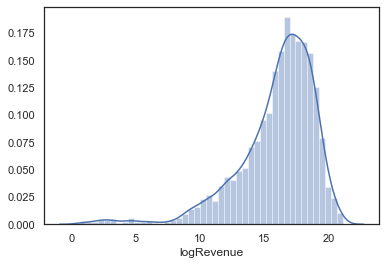

In [80]:
train['logRevenue'] = np.log1p(train['revenue'])
sns.distplot(train['logRevenue'])

In [81]:
train.drop(columns=['logRevenue'], axis=1, inplace=True)

In [82]:
train.corr()

,id,budget,popularity,runtime,revenue,has_homepage,has_collection,og_language,top3_prod_comp,Action,...,Mystery,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA,has_tagline,release_day
id,1.000000,0.020363,-0.006715,0.016303,0.000834,-0.005851,-0.011840,-0.015738,-0.018425,0.028351,...,0.005117,-0.005894,0.026475,-0.014871,-0.005392,-0.022270,-0.005221,0.002695,-0.016688,-0.001432
budget,0.020363,1.000000,0.341520,0.239769,0.752855,0.247052,0.223186,-0.120668,0.209133,0.276529,...,-0.001295,-0.090273,0.190069,0.062991,0.020682,-0.009962,0.100742,0.246825,0.215009,-0.117090
popularity,-0.006715,0.341520,1.000000,0.128770,0.461051,0.164028,0.156069,-0.102636,0.086800,0.105141,...,0.027641,-0.053970,0.082363,0.046626,0.018854,0.000736,0.035160,0.150310,0.161547,-0.094691
runtime,0.016303,0.239769,0.128770,1.000000,0.219677,0.032925,-0.040679,0.149697,0.081105,0.097027,...,0.004511,0.059822,-0.040131,0.000397,0.134480,0.064451,0.179298,-0.097322,-0.029563,-0.089966
revenue,0.000834,0.752855,0.461051,0.219677,1.000000,0.262887,0.340101,-0.090112,0.176742,0.184769,...,-0.015133,-0.049961,0.134072,0.006802,-0.022997,-0.013252,0.064099,0.196162,0.178777,-0.141893
has_homepage,-0.005851,0.247052,0.164028,0.032925,0.262887,1.000000,0.060304,-0.021323,-0.023471,0.040501,...,-0.022255,-0.064071,0.051858,-0.006373,-0.006509,-0.038412,0.060356,0.036058,0.068950,-0.055340
has_collection,-0.011840,0.223186,0.156069,-0.040679,0.340101,0.060304,1.000000,0.016058,0.106416,0.183935,...,0.002114,-0.154361,0.136423,0.063348,-0.014601,-0.045800,0.046392,0.082967,0.113258,-0.044538
og_language,-0.015738,-0.120668,-0.102636,0.149697,-0.090112,-0.021323,0.016058,1.000000,-0.116361,0.011507,...,-0.003164,-0.006009,-0.033712,-0.061921,0.065324,-0.023050,0.028441,-0.472671,-0.335096,0.005643
top3_prod_comp,-0.018425,0.209133,0.086800,0.081105,0.176742,-0.023471,0.106416,-0.116361,1.000000,0.078556,...,0.051285,-0.045219,0.030114,0.057683,-0.016210,0.002078,-0.014115,0.225238,0.164397,-0.013114
Action,0.028351,0.276529,0.105141,0.097027,0.184769,0.040501,0.183935,0.011507,0.078556,1.000000,...,-0.051876,-0.177260,0.194850,0.270066,0.070160,0.030392,0.105755,0.035808,0.097123,-0.046797


In [83]:
train['popularity'] = train['popularity'].astype(int)
test['popularity'] = test['popularity'].astype(int)
train['runtime'] = train['runtime'].astype(int)
test['runtime'] = test['runtime'].astype(int)
test['release_day'] = test['release_day'].astype(int)

### Linear Regression:

In [84]:
X = train[['budget', 'popularity', 'runtime', 'has_homepage', 'has_collection', 'Adventure',
                  'produced_in_USA', 'has_tagline', ]]
y = train.revenue

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

#Linear Model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
def rmsle(y,y0): return np.sqrt(np.mean(np.square(np.log1p(y)-np.log1p(y0)))) 
reg = LinearRegression()
lin_model = reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
print('RMSLE score for linear model is {}'.format(rmsle(y_val, y_pred)))

#Applyting the model on test data and submission
X_test = test[['budget', 'popularity', 'runtime', 'has_homepage', 'has_collection', 'Adventure',
                  'produced_in_USA', 'has_tagline', ]]
pred1 = reg.predict(X_test)

RMSLE score for linear model is 1.64429054747612


### Random Forest Regressor:

In [85]:
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='most_frequent')

#imputer.fit_transform(X)
#imputer.fit_transform(X_test)

def rmsle(y,y0): return np.sqrt(np.mean(np.square(np.log1p(y)-np.log1p(y0))))
y = train.revenue

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

rf = RandomForestRegressor()
rf_model = rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_val)
print('RMSLE score for Random Forest model is {}'.format(rmsle(y_val, rf_y_pred)))
pred3 = rf.predict(X_test)

RMSLE score for Random Forest model is 2.0304704321067066
